# Variational autoencoder

MNIST 데이터셋을 사용하는 VAE를 만들어봅시다.<br>

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.<br>
Modified by uramoon@kw.ac.kr

**이미지 출처: Jeremy Jordan's [blog post](https://www.jeremyjordan.me/variational-autoencoders/)**

기존에 실습한 오토인코더는 입력 이미지를 결정적인 방법으로 인코딩합니다. (같은 그림은 무조건 같은 장소로 보냄) <br>
![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/int1.png)
Variational autoencoder (VAE)는 입력 이미지를 확률적인 방법으로 인코딩합니다.
![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/int3.png)<br> 특정 좌표에 여러 이미지가 맵핑될 수 있으므로 해당 좌표 근처에는 비슷한 이미지들이 위치하게 됩니다. 
![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/int4.png)

## Setup

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 샘플링 층 만들기
주어진 평균과 분산을 이용해 정규분포에서 무작위로 값을 추출하는 층

이미지 출처: [DLAI-s2-2020](https://erodola.github.io/DLAI-s2-2020/)<br>
![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/implementation.png)

In [47]:
# 이해하지 않으셔도 됩니다.
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs  # inputs에 평균과 분산(로그)가 들어가 있음
        batch = tf.shape(z_mean)[0] # 그림 장수 알아오기
        dim = tf.shape(z_mean)[1]   # 잠재 공간의 차원 알아오기
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # epsilon은 표준 정규분포 추출해낸 값
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # 주어진 평균과 분산을 이용해 정규분포에서 무작위로 값을 추출

## TODO: 인코더 만들기
인코더는 각 그림 (28 x 28)을 2차원(latent_dim) 공간상의 좌표로 보냅니다.<br>
7 * 7 * 64 일차원 배열에서 무언가 값을 두 개 계산하여 평균으로 삼고, 또 다른 무언가 값을 두 개 계산하여 분산(로그)으로 삼습니다.<br>
(평균을 구하는 층과 분산을 구하는 층이 동일한 배열을 입력받기 때문에 Sequential 모델 사용 불가)<br>
각 차원의 좌표는 평균과 분산(로그)을 이용해 Sampling 층이 정규분포에서 추출하므로 확률적인 방식으로 결정됩니다.<br>

In [48]:
latent_dim = 2

# TODO: MNIST 행, 열, 채널(흑백:1, 컬러:3) 기재
encoder_inputs = keras.Input(shape=(28, 28, 1)) 

#
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)  # (14, 14, 32)로 변환
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)               # (7, 7, 64)로 변환
x = layers.Flatten()(x)                                                                 # 7 * 7 * 64 일차원 배열로 변환

z_mean = layers.Dense(latent_dim, name="z_mean")(x)         # 7 * 7 * 64를 입력받아 실수값 두 개를 출력하여 평균으로 사용
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)   # 7 * 7 * 64를 입력받아 실수값 두 개를 출력하여 분산(로그)으로 사용
z = Sampling()([z_mean, z_log_var])                         # 정규분포에서 z값 (이차원 좌표)을 추출, 디코더에 넘겨주는 값

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder") # Model(입력, 출력, 모델 이름)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 14, 14, 32)   320         ['input_11[0][0]']               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_10[0][0]']              
                                                                                                  
 flatten_5 (Flatten)            (None, 3136)         0           ['conv2d_11[0][0]']              
                                                                                            

## TODO: 디코더 만들기
상기 인코더와 대칭이 되도록 만듭니다. Conv2D는 이미지 사이즈를 줄여주고, Conv2DTranspose는 이미지 사이즈를 키워줍니다.<br>
1. Conv2D가 784 (28x28)개의 픽셀을 196 (14x14)개의 픽셀로 줄여주는 행렬이라면 Conv2D는 196x784 모양의 행렬이어야 함. (196x784) 행렬 x (784x1) 행렬의 결과는 196x1. (14x14로 해석 가능)
2. 196 (14x14)개의 픽셀을 784 (28x28)로 늘릴려면 784x196 모양의 행렬을 곱해야 함. (784x196) 행렬 x (196x1) 행렬의 결과는 784x1. (28x28로 해석 가능) 여기에서 784x196은 Conv2D의 전치행렬 모양과 동일하기 때문에 Conv2DTranspose로 이름이 붙음.

In [49]:
latent_inputs = keras.Input(shape=(latent_dim,))                # 인코더가 출력한 z 값(이차원 좌표)을 입력받음
x = layers.Dense(7*7*64, activation="relu")(latent_inputs)       # 이차원 좌표에서 7 * 7 * 64 일차원 배열 생성
x = layers.Reshape((7, 7, 64))(x)                               # (7, 7, 64)로 변환
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)                  # (14, 14, 32)로 변환
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", strides=2, padding="same")(x)  # (28, 28, 1)로 변환
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 14, 14, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 28, 28, 1)        289       
 Transpose)                                                      
                                                                 
Total params: 28,161
Trainable params: 28,161
Non-trainable

## Define the VAE as a `Model` with a custom `train_step`
훈련할 때 이미지 복원을 얼마나 잘하는지 측정하는 loss와 평균과 표준편차가 표준정규분포(평균:0, 분산:1)에서 멀어지는 것에 페널티를 주는 loss를 사용합니다. 두 번째 loss는 이미지들을 원점과 가까운 곳에 맵핑시키기 위한 것입니다. (나중에 그림을 생성하고 싶으면 원점 근처에서 샘플링하면 됨)

In [50]:
# 이해하지 않아도 됩니다.
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data) # 그림을 인코더로 변환
            reconstruction = self.decoder(z)          # 2차원 좌표를 받아 그림을 복원
            reconstruction_loss = reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(                    
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)  # 복원 loss
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))        # 평균과 분산이 표준정규분포(평균:0, 분산:1)에서 멀어지는 것에 페널티를 주는 loss
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## TODO: Train the VAE
그림을 두 개의 실수로 인코딩한 후 디코딩하여 원래의 그림을 복원하는 것이 목적이므로 y값은 사용할 필요가 없습니다.

In [51]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
#x_train = np.concatenate([x_train], axis=0)
print(np.expand_dims(x_train,-1).shape)

print(np.expand_dims(x_test,-1).shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [52]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# TODO: x_train과 x_test를 (장수, 세로, 가로, 채널)로 모양을 바꾸고 0과 1사이로 정규화하세요.
x_train = np.expand_dims(x_train,-1).astype("float32") / 255
x_test = np.expand_dims(x_test,-1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 7s 10ms/step - loss: 286.5782 - reconstruction_loss: 213.1203 - kl_loss: 6.1953
Epoch 2/30
469/469 [==============================] - 3s 7ms/step - loss: 175.2845 - reconstruction_loss: 168.2388 - kl_loss: 4.6052
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 167.4401 - reconstruction_loss: 161.6736 - kl_loss: 4.7578
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - loss: 163.3982 - reconstruction_loss: 157.9320 - kl_loss: 4.9913
Epoch 5/30
469/469 [==============================] - 6s 12ms/step - loss: 161.4978 - reconstruction_loss: 155.7014 - kl_loss: 5.1264
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - loss: 159.9714 - reconstruction_loss: 154.3745 - kl_loss: 5.2361
Epoch 7/30
469/469 [==============================] - 4s 10ms/step - loss: 158.6689 - reconstruction_loss: 153.4043 - kl_loss: 5.2958
Epoch 8/30
469/469 [==============================] - 3s 7ms/step 

## Display a grid of sampled digits
잠재공간 차원이 2차원일 때에만 실행하세요.

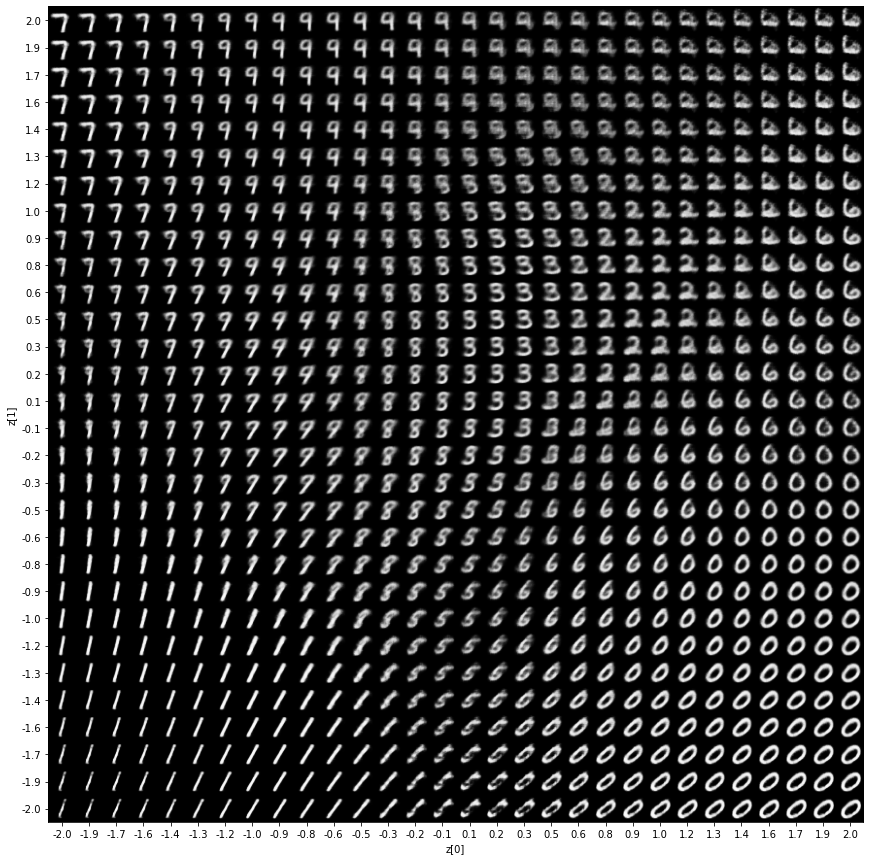

In [53]:
# 2차원 좌표에 저장된 이미지 그리기, 이해하실 필요 없습니다.
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 2.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

## TODO: 인코더와 디코더 사용
오토인코더의 앞 부분을 인코더, 뒷 부분을 디코더로 사용합니다.

In [68]:
x_test.shape

(10000, 28, 28, 1)

In [55]:
# TODO: 테스트 데이터의 처음 10장을 인코딩
# Hint: 인코더의 출력은 [z_mean, z_log_var, z]입니다. 이 중에 무엇을 사용할까요?
# z 사용

# 원래는 z_mean을 사용하면 더 정확하게 / z_log_var로 인해 흐트러진 z값
encoded_imgs = encoder.predict(x_test[0:10]) #TODO

# 2차원 상의 좌표로 변환된 그림 10장
encoded_imgs


[array([[-1.3136847 ,  0.48939717],
        [ 1.221757  ,  0.52404827],
        [-1.7532519 , -1.6213577 ],
        [ 1.2806978 , -0.75727296],
        [-0.32988483,  1.7097958 ],
        [-1.4975524 , -1.272397  ],
        [-1.0122185 ,  1.1417155 ],
        [-0.0660525 ,  2.5006528 ],
        [ 0.07222915,  0.20199607],
        [-0.9309622 , -0.06266453]], dtype=float32),
 array([[-6.289651 , -5.6723847],
        [-6.175353 , -6.2969003],
        [-4.950884 , -4.9768767],
        [-5.724073 , -5.8588834],
        [-4.840314 , -4.428351 ],
        [-5.382782 , -5.087919 ],
        [-5.3863916, -4.8092103],
        [-5.297546 , -4.412486 ],
        [-6.045592 , -5.1913633],
        [-6.6928678, -6.286883 ]], dtype=float32),
 array([[-1.280966  ,  0.5490117 ],
        [ 1.211833  ,  0.5500243 ],
        [-1.7647998 , -1.5338336 ],
        [ 1.1992844 , -0.70164967],
        [-0.28008038,  1.5893686 ],
        [-1.4857363 , -1.2581619 ],
        [-1.0699447 ,  1.0824604 ],
        [ 0.00

In [62]:
print(encoded_imgs[2])

[[-1.280966    0.5490117 ]
 [ 1.211833    0.5500243 ]
 [-1.7647998  -1.5338336 ]
 [ 1.1992844  -0.70164967]
 [-0.28008038  1.5893686 ]
 [-1.4857363  -1.2581619 ]
 [-1.0699447   1.0824604 ]
 [ 0.00821093  2.4159055 ]
 [ 0.07339408 -0.07392062]
 [-0.89541566 -0.09045368]]


In [56]:
# TODO: 인코딩된 그림을 디코딩
decoded_imgs = decoder.predict(encoded_imgs[2])

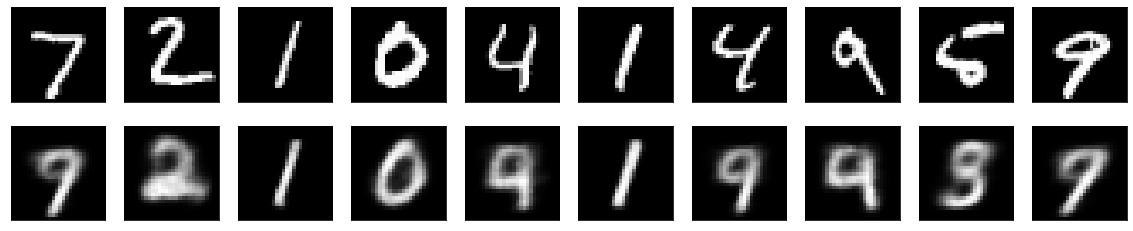

In [57]:
# 원본 그림과 오토인코더가 출력한 그림 그려보기 (이해하실 필요 없습니다.)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 무작위로 숫자 그림 생성해보기

In [63]:
# TODO: 2개의 실수로 구성된 10장의 인코딩된 그림을 생성합니다.
rand_encoded_imgs = np.random.randn(10, 2)

# TODO: 디코딩합니다.
decoded_imgs = decoder.predict(rand_encoded_imgs)

### 그려보기
지난 번 단순한 오토인코더와 비교해보세요. 바로 위의 코드 블록을 실행하고 다시 그려보면 새로운 그림이 그려집니다.

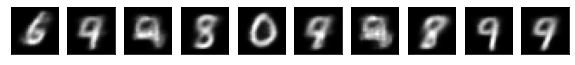

In [64]:
n = 10  # How many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 잠재공간 차원 늘리기
2차원을 10차원으로 늘려 모델 정의, 훈련, 인코더와 디코더 사용, 무작위로 숫자 이미지 생성을 해보세요.<br>


In [65]:
# 모델 정의
latent_dim = 10

# TODO: MNIST 행, 열, 채널(흑백:1, 컬러:3) 기재
encoder_inputs = keras.Input(shape=(28, 28, 1)) 

# encoder
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)  # (14, 14, 32)로 변환
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)               # (7, 7, 64)로 변환
x = layers.Flatten()(x)                                                                 # 7 * 7 * 64 일차원 배열로 변환

z_mean = layers.Dense(latent_dim, name="z_mean")(x)         # 7 * 7 * 64를 입력받아 실수값 두 개를 출력하여 평균으로 사용
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)   # 7 * 7 * 64를 입력받아 실수값 두 개를 출력하여 분산(로그)으로 사용
z = Sampling()([z_mean, z_log_var])                         # 정규분포에서 z값 (이차원 좌표)을 추출, 디코더에 넘겨주는 값

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder") # Model(입력, 출력, 모델 이름)

# decoder
latent_inputs = keras.Input(shape=(latent_dim,))                # 인코더가 출력한 z 값(이차원 좌표)을 입력받음
x = layers.Dense(7*7*64, activation="relu")(latent_inputs)       # 이차원 좌표에서 7 * 7 * 64 일차원 배열 생성
x = layers.Reshape((7, 7, 64))(x)                               # (7, 7, 64)로 변환
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)                  # (14, 14, 32)로 변환
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", strides=2, padding="same")(x)  # (28, 28, 1)로 변환
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# 데이터 준비
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# TODO: x_train과 x_test를 (장수, 세로, 가로, 채널)로 모양을 바꾸고 0과 1사이로 정규화하세요.
x_train = np.expand_dims(x_train,-1).astype("float32") / 255
x_test = np.expand_dims(x_test,-1).astype("float32") / 255

# 훈련
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_6 (Dense)             (None, 3136)              34496     
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 14, 14, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 28, 28, 1)        289       
 Transpose)                                                      
                                                                 
Total params: 53,249
Trainable params: 53,249
Non-trainable

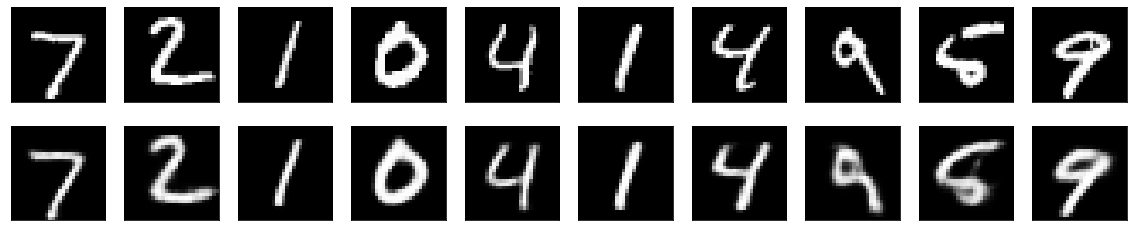

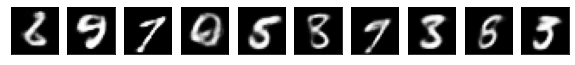

In [66]:
# 인코더와 디코더 사용
encoded_imgs = encoder.predict(x_test[0:10]) #TODO

decoded_imgs = decoder.predict(encoded_imgs[2])

# 원본 그림과 오토인코더가 출력한 그림 그려보기
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("========================================================================================================================================================")

# 무작위로 생성
# 10개의 실수로 구성된 10장의 인코딩된 그림을 생성합니다.
rand_encoded_imgs = np.random.randn(10, 10)

# TODO: 디코딩합니다.
decoded_imgs = decoder.predict(rand_encoded_imgs)


n = 10  # How many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Q: 이미지 복원 능력과 생성물의 품질에 차이가 있나요?
# A: 차원을 늘리면 품질이 더 좋아진다